In [2]:
import sys
sys.path.append("..")

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.manifold import SpectralEmbedding, TSNE, MDS
import torch
import umap
from sklearn.preprocessing import StandardScaler
import hdbscan


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


## Read data

In [6]:
df = pd.read_csv("data.csv")

# Select meaningful physical variables
#features = ['v', 'T', 'u', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
#       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2' ]
# features = ['u', 'v', 'T', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
#        'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
#        'curvature', 'stretch_rate', 'disp_speed_density_weighted',
#        'abs_flame_prop_vel_normal', 'flow_velocity_normal',
#        'flow_velocity_tangential', 'tangential_strain_rate',
#        'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
#        'vorticity', 'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O',
#        'omega_OH', 'omega_HO2', 'omega_H2O2', 'omega_N2', 'Le_def']
features = [
    'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
    'omega_HO2', 'omega_H2O2', 'omega_N2'
]
df = df[(df['x'] >160) & (df['x'] < 190)]
colourmap = df["disp_speed_density_weighted"]
X = StandardScaler().fit_transform(df[features])


£## UMAP

In [ ]:
# UMAP embedding
reducer = umap.UMAP(n_neighbors=20, n_components=2, init = "random" )
X_embedded = reducer.fit_transform(X)
# Plot
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 2811


## UMAP -> HDBSCAN -> MI -> Mapping to original space
Taken from "Identifying key features in reactive flows: A tutorial on combining
dimensionality reduction, unsupervised clustering, and feature correlation"

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster summary: {np.int64(-1): np.int64(67315), np.int64(0): np.int64(36643), np.int64(1): np.int64(640), np.int64(2): np.int64(1280), np.int64(3): np.int64(638), np.int64(4): np.int64(395), np.int64(5): np.int64(2218), np.int64(6): np.int64(413), np.int64(7): np.int64(640), np.int64(8): np.int64(427), np.int64(9): np.int64(396), np.int64(10): np.int64(3650), np.int64(11): np.int64(1789), np.int64(12): np.int64(640), np.int64(13): np.int64(665), np.int64(14): np.int64(569), np.int64(15): np.int64(455), np.int64(16): np.int64(700), np.int64(17): np.int64(627), np.int64(18): np.int64(1522), np.int64(19): np.int64(1317), np.int64(20): np.int64(1783), np.int64(21): np.int64(555), np.int64(22): np.int64(390), np.int64(23): np.int64(801), np.int64(24): np.int64(1164), np.int64(25): np.int64(420), np.int64(26): np.int64(2486), np.int64(27): np.int64(379), np.int64(28): np.int64(388), np.int64(29): np.int64(3897), np.int64(30): np.int64(4726), np.int64(31): np.int64(416), np.int64(32): np.int

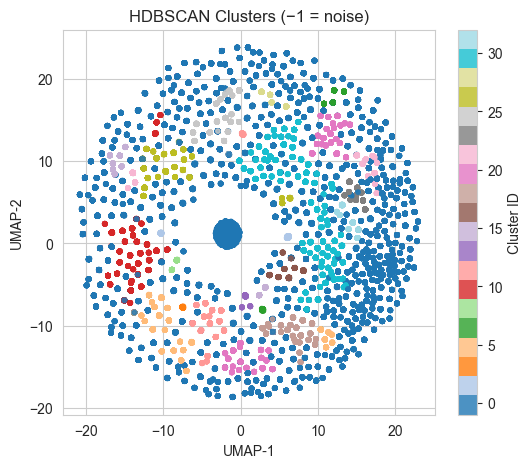

In [36]:
# ============================================================
# HDBSCAN CLUSTERING
# ============================================================
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(np.sqrt(len(X))),
    min_samples=int(np.sqrt(len(X))),
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
).fit(X_embedded)

labels = clusterer.labels_
proba  = clusterer.probabilities_
outlier_scores = clusterer.outlier_scores_

unique, counts = np.unique(labels, return_counts=True)
cluster_summary = dict(zip(unique, counts))
print("Cluster summary:", cluster_summary)
print("Number of clusters (excluding noise):", len(set(labels)) - (1 if -1 in labels else 0))
print("Noise fraction:", np.mean(labels == -1))
print("Average cluster probability:", proba[labels != -1].mean() if np.any(labels != -1) else 0)

# ============================================================
# UMAP SPACE PLOT
# ============================================================
plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_embedded[:,0], X_embedded[:,1],
    c=labels, cmap='tab20', s=10, alpha=0.8
)
plt.title("HDBSCAN Clusters (−1 = noise)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()


Global mutual information ranking:
      feature   MI_dim1   MI_dim2    MI_sum
7  omega_H2O2  4.488562  4.473628  8.962191
6   omega_HO2  4.319114  4.310310  8.629424
1    omega_O2  4.301841  4.291613  8.593453
5    omega_OH  4.201044  4.185845  8.386889
3     omega_H  4.186454  4.175293  8.361747
2   omega_H2O  4.178950  4.165615  8.344565
4     omega_O  4.110302  4.095488  8.205790
0    omega_H2  3.795530  3.771884  7.567414
8    omega_N2  0.008083  0.007116  0.015199


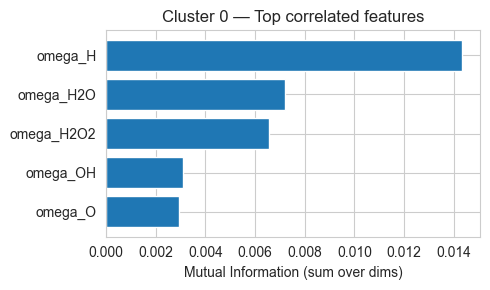

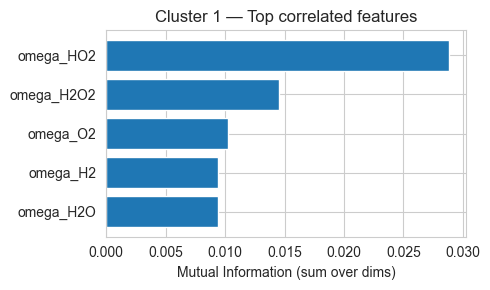

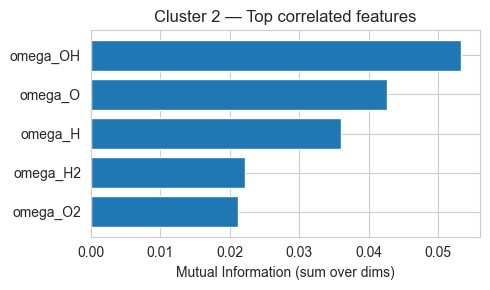

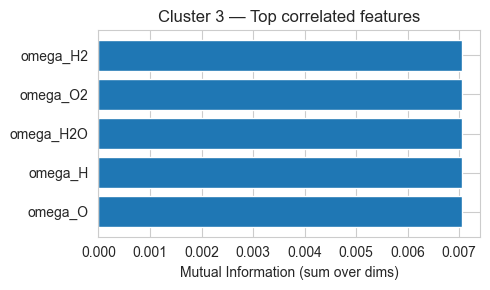

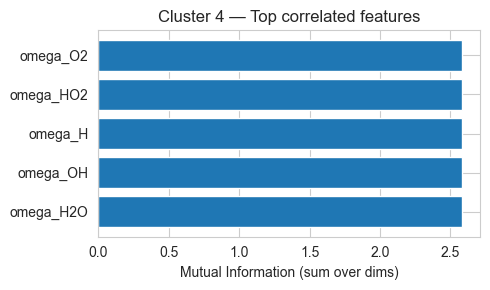

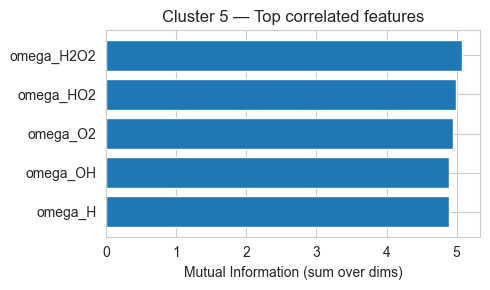

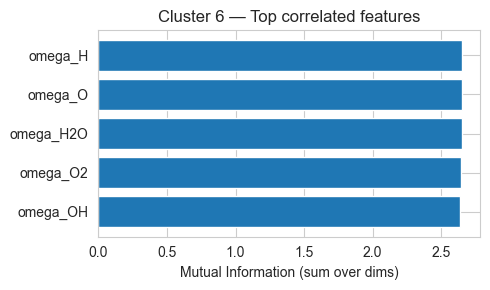

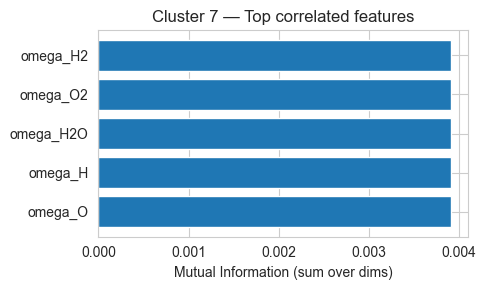

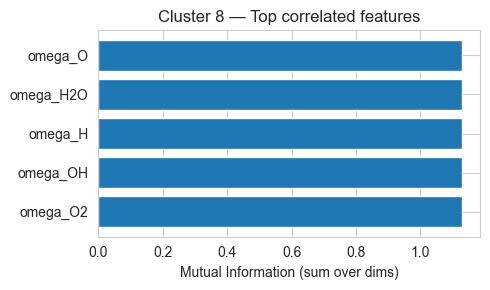

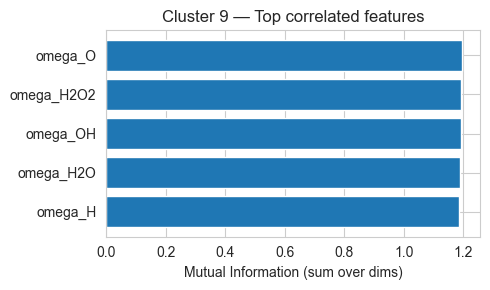

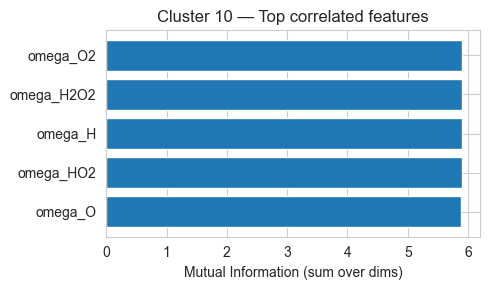

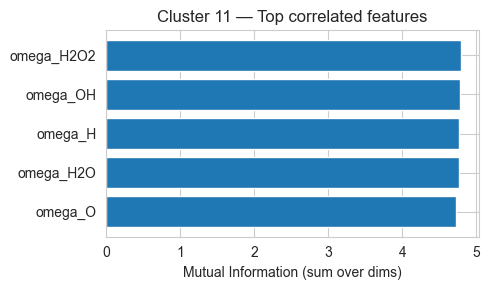

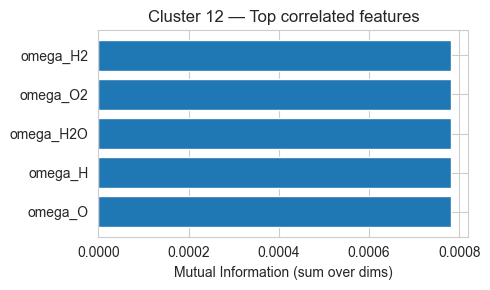

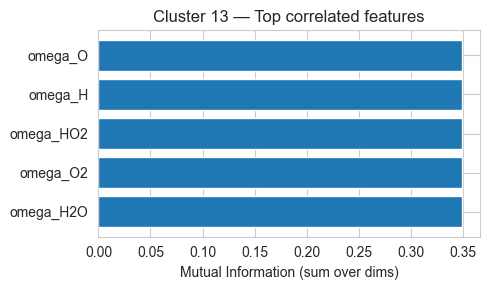

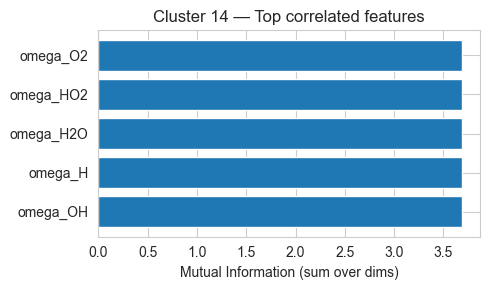

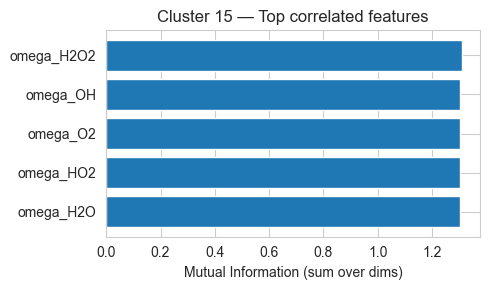

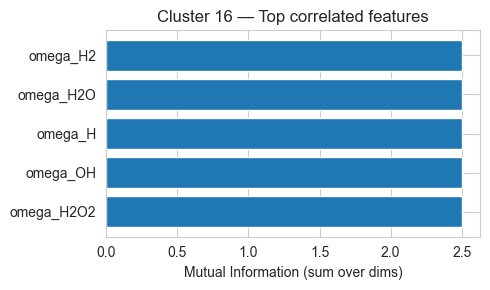

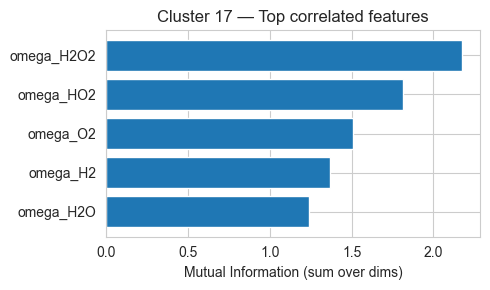

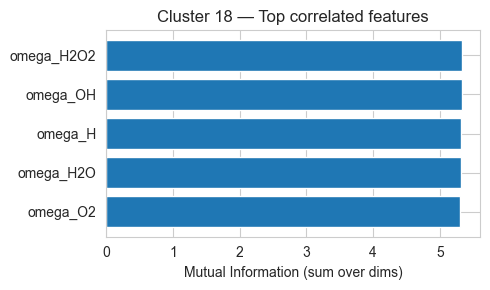

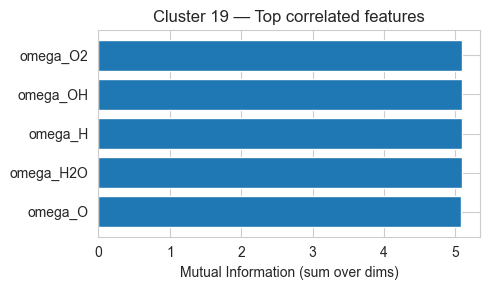

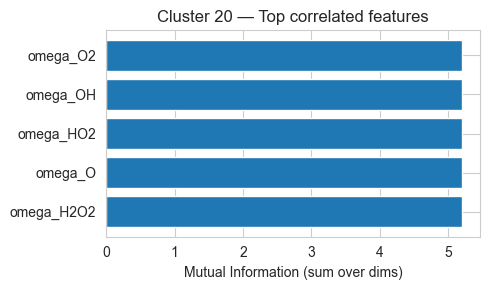

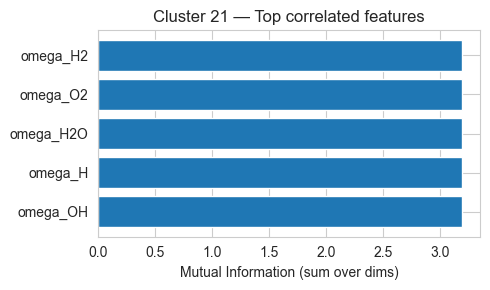

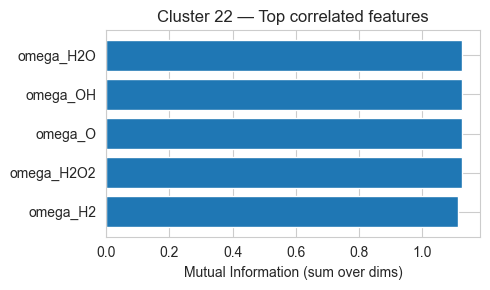

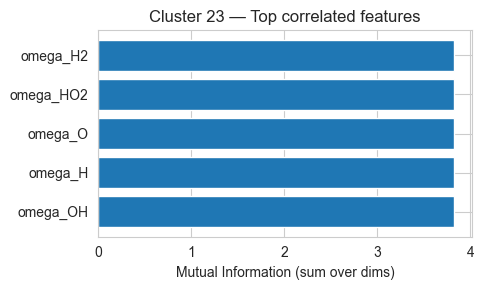

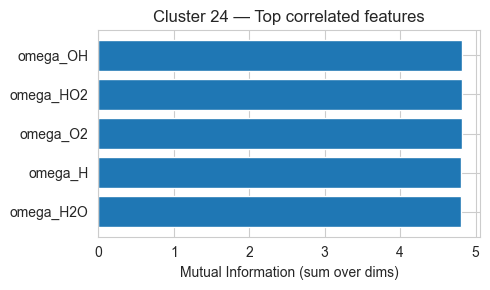

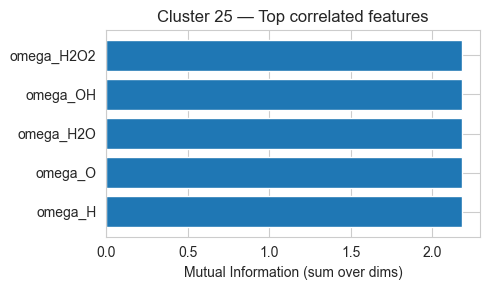

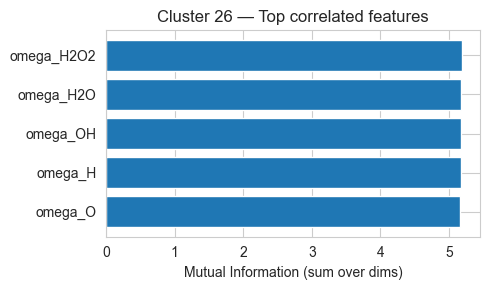

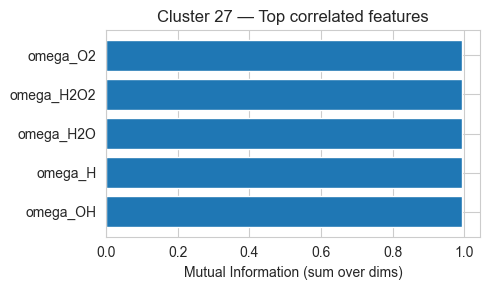

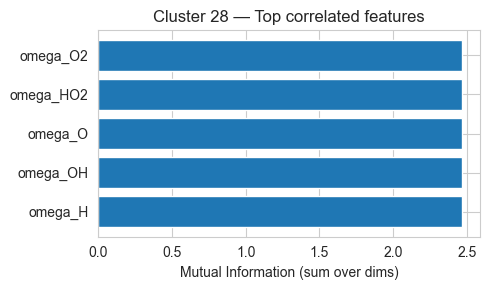

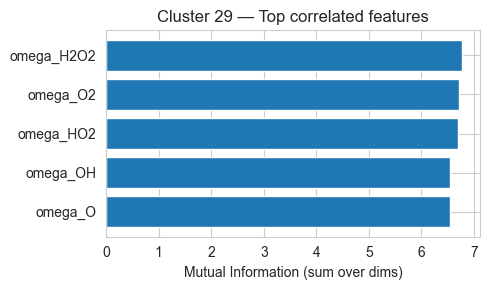

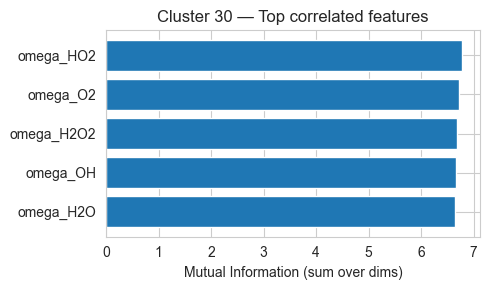

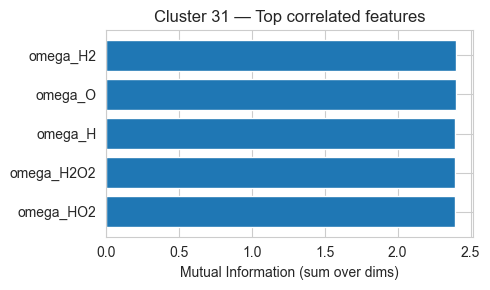

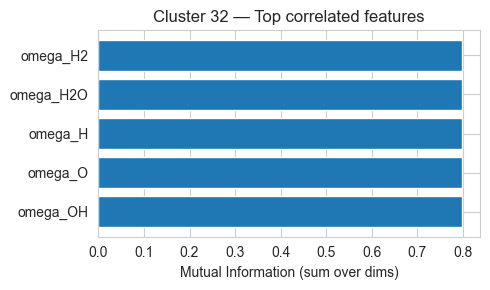

In [37]:

# ============================================================
# GLOBAL MUTUAL INFORMATION
# ============================================================
from sklearn.feature_selection import mutual_info_regression

mi_x1 = mutual_info_regression(X, X_embedded[:, 0], random_state=0)
mi_x2 = mutual_info_regression(X, X_embedded[:, 1], random_state=0)

df_mi_global = pd.DataFrame({
    'feature': features,
    'MI_dim1': mi_x1,
    'MI_dim2': mi_x2,
    'MI_sum':  mi_x1 + mi_x2
}).sort_values('MI_sum', ascending=False)

print("Global mutual information ranking:")
print(df_mi_global.head(10))
# ============================================================
# PER-CLUSTER MUTUAL INFORMATION
# ============================================================
cluster_labels = sorted(set(labels) - {-1})
mi_cluster = {}

for cluster in cluster_labels:
    mask = labels == cluster
    if mask.sum() < 10:
        continue

    mi1 = mutual_info_regression(X[mask], X_embedded[mask, 0], random_state=0)
    mi2 = mutual_info_regression(X[mask], X_embedded[mask, 1], random_state=0)

    df_new = pd.DataFrame({
        'feature': features,
        'MI_dim1': mi1,
        'MI_dim2': mi2,
        'MI_sum':  mi1 + mi2
    }).sort_values('MI_sum', ascending=False)

    mi_cluster[cluster] = df_new


# Plot top correlations
for cluster, df_new in mi_cluster.items():
    top = df_new.head(5)
    plt.figure(figsize=(5,3))
    plt.barh(top['feature'][::-1], top['MI_sum'][::-1])
    plt.xlabel("Mutual Information (sum over dims)")
    plt.title(f"Cluster {cluster} — Top correlated features")
    plt.tight_layout()
    plt.show()



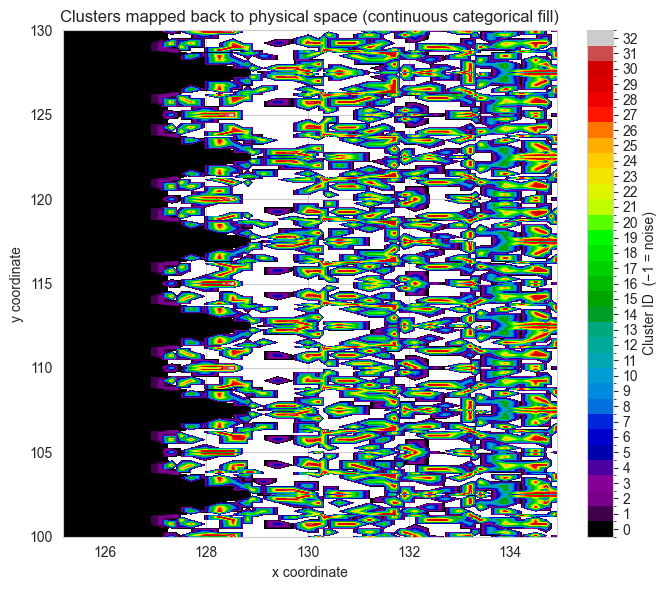

             omega_H2      omega_O2     omega_H2O       omega_H       omega_O  \
cluster                                                                         
-1       2.016013e+12 -4.643653e+12  3.765304e+13 -5.656489e+13 -1.060300e+13   
 0      -2.340553e+02  5.153349e+01  2.324773e+02  2.340573e+02 -1.001876e+01   
 1      -4.439820e-07  2.239174e+06 -1.971646e-16  4.439820e-07  3.117181e-67   
 2      -3.100855e+02  1.271205e+04  0.000000e+00  3.100855e+02 -2.572794e+04   
 3      -3.360744e+05  2.151790e+02  3.360351e+05  3.361082e+05 -4.358095e+02   

             omega_OH     omega_HO2    omega_H2O2  omega_N2  
cluster                                                      
-1      -2.805195e+13  5.010473e+12  1.341349e+11       0.0  
 0      -2.306983e+02 -9.462422e+01  4.721064e+01       0.0  
 1       1.971646e-16 -4.478348e+06  2.239174e+06       0.0  
 2       3.140749e+02 -6.248185e+00  1.129386e+00       0.0  
 3      -3.362975e+05  5.232229e-25  1.339266e+02       0.0 

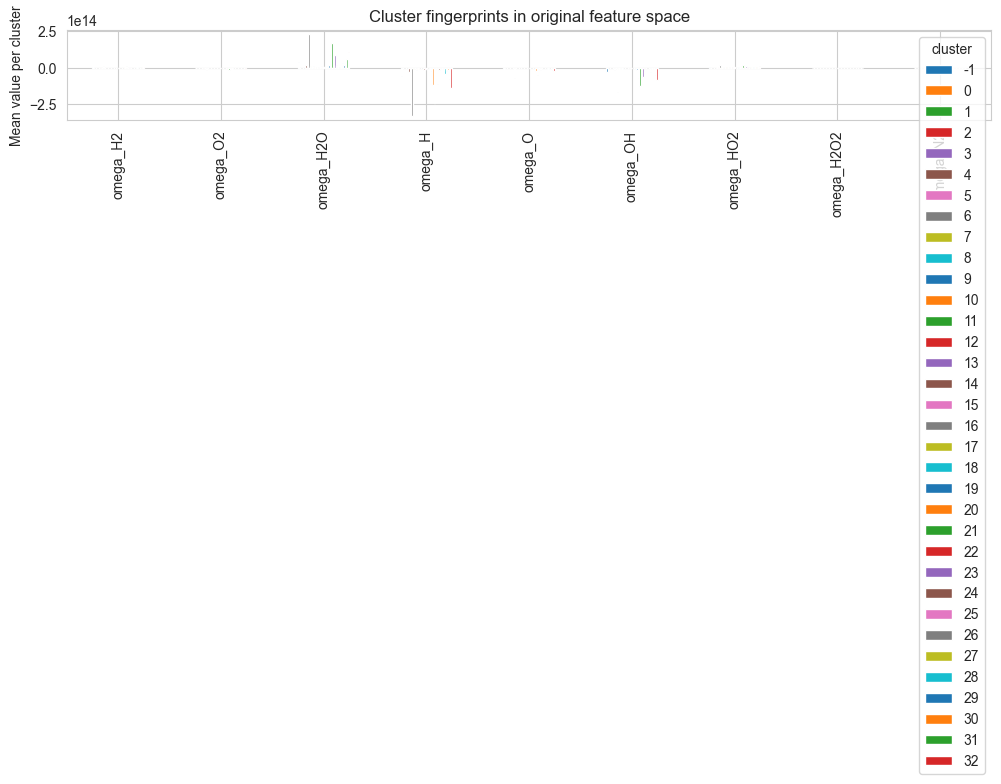

In [39]:

# ============================================================
# CONTINUOUS CATEGORICAL CLUSTER FIELD IN PHYSICAL SPACE
# (REPLACEMENT OF SCATTER PLOT)
# ============================================================
import matplotlib.tri as mtri

from matplotlib.colors import BoundaryNorm
import matplotlib as mat

# Build triangulation once (use your df['x'], df['y'])
tri = mtri.Triangulation(df['x'].to_numpy(), df['y'].to_numpy())

k = len(np.unique(labels)) - (1 if -1 in labels else 0)

# Select categorical colormap
cmap = mat.colormaps.get_cmap("nipy_spectral")

# Discrete boundaries: one color per cluster ID (including noise)
bounds = np.arange(-0.5, labels.max() + 1.5, 1)
norm   = BoundaryNorm(bounds, cmap.N)

z = labels  # cluster assignment per point

plt.figure(figsize=(7,6))

c = plt.tricontourf(
    df['x'], df['y'], z,
    levels=bounds,
    cmap=cmap,
    norm=norm
)

cb = plt.colorbar(c, ticks=np.arange(labels.min(), labels.max()+1))
cb.set_label("Cluster ID  (−1 = noise)")

plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.ylim((100,130))
plt.title("Clusters mapped back to physical space (continuous categorical fill)")
plt.tight_layout()
plt.show()


# ============================================================
# STATISTICS + FINGERPRINTS
# ============================================================
df_with_labels = df.copy()
df_with_labels["cluster"] = labels

cluster_means = df_with_labels.groupby("cluster")[features].mean()
cluster_stds  = df_with_labels.groupby("cluster")[features].std()

print(cluster_means.head())

cluster_means.T.plot(kind='bar', figsize=(10,5))
plt.ylabel("Mean value per cluster")
plt.title("Cluster fingerprints in original feature space")
plt.tight_layout()
plt.show()


## Spectral Embedding

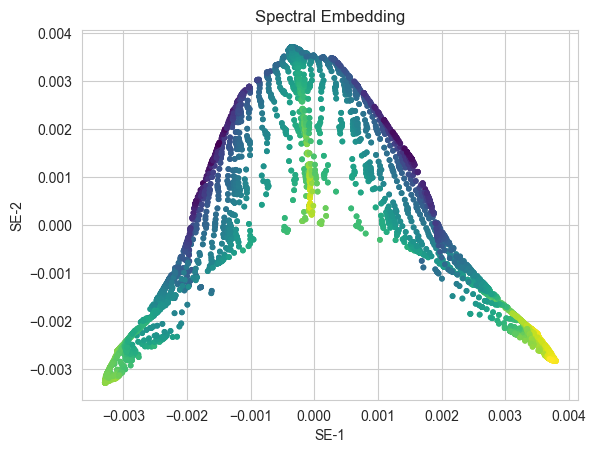

In [17]:
SE = SpectralEmbedding(n_components=2, n_neighbors=30)
X_SE = SE.fit_transform(X)
# Plot
plt.scatter(X_SE[:,0], X_SE[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("Spectral Embedding")
plt.xlabel("SE-1")
plt.ylabel("SE-2")
plt.show()

## t-SNE

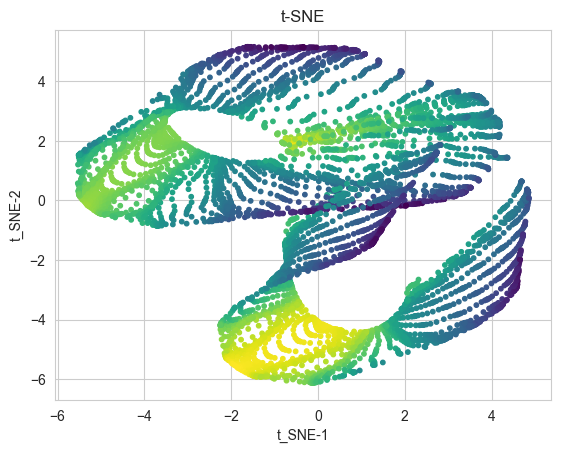

In [18]:
t_sne = TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    max_iter=250,
    random_state=0,
)
X_sne = t_sne.fit_transform(X)

plt.scatter(X_sne[:,0], X_sne[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("t-SNE")
plt.xlabel("t_SNE-1")
plt.ylabel("t_SNE-2")
plt.show()


## Multidimensional Scaling

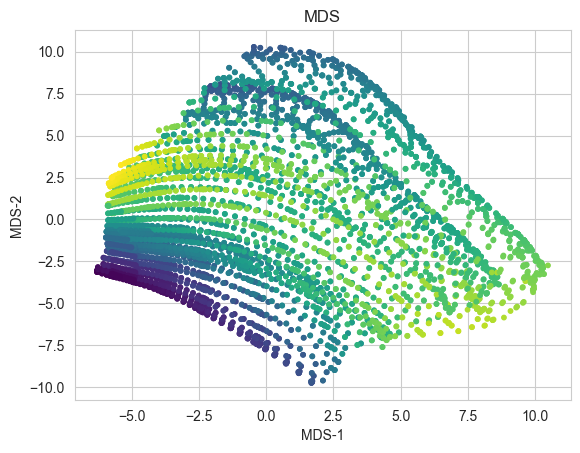

In [27]:
mds_embedding = MDS(n_components=2, n_init=1)
X_mds = mds_embedding.fit_transform(X)

plt.scatter(X_mds[:,0], X_mds[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("MDS")
plt.xlabel("MDS-1")
plt.ylabel("MDS-2")
plt.show()
